## Test 12/07/2024 - Update Retrieval Evaluation process

Goal:
The previous tests were conducted using a dataset comprising the 100 largest available documents from the raw database. As a result, this high-quality content may not accurately reflect the distribution of data in the entire vector database. While we can observe differences between the configurations, it is challenging to determine which combination is the best choice for our use case among the top configurations.

Several experiments will be done : 
- add random documents to the base corpus (uniformly distributed)
- add other big documents to the base corpus (keeping the same extraction procedure of the top N largest content documents)

what to observe : 
- evolution of the retrieval metrics facing this added noise. 

Assumption : run python src/db_building/insee_data_processing.py in the terminal

In [17]:
import sys
import os 
import pandas as pd
import numpy as np

In [11]:
data = pd.read_csv("/home/onyxia/work/llm-open-data-insee/data_complete.csv", low_memory=False) #we assume the textual information have already been extracted. 

In [12]:
from db_building import extract_paragraphs
results = extract_paragraphs(data) 

43226it [01:22, 522.40it/s] 


In [13]:
ds = pd.DataFrame.from_dict(results)
ds.to_csv("insee_documents.csv", index=False)

In [2]:
ds = pd.read_csv("insee_documents.csv")

In [3]:
ds.head()

,id_origin,paragraphs,url_source,title,categories,dateDiffusion,themes,collections,libelleAffichageGeo,intertitres,authors,subtitle
0,1280888,"Entre 2008 et 2010, dans un contexte de crise,...",https://www.insee.fr/fr/statistiques/1280888,Innover pour résister à la crise ou se dévelop...,Publications grand public,2012-10-23T22:00:00Z,"Mondialisation, compétitivité et innovation",Insee Première,France,"Entre 2008 et 2010, la moitié des sociétés de ...",NaN,NaN
1,1280890,"En 2011, le déficit public s’établit à 103,1mi...",https://www.insee.fr/fr/statistiques/1280890,Les comptes des administrations publiques en 2011,Publications grand public,2012-05-15T05:30:00Z,Finances publiques,Insee Première,France,"En 2011, le déficit public atteint 5,2 % du PI...",NaN,NaN
2,1280892,L’année agricole 2012 est marquée par l’abonda...,https://www.insee.fr/fr/statistiques/1280892,Les comptes prévisionnels de l’agriculture pou...,Publications grand public,2012-12-12T16:00:00Z,Agriculture,Insee Première,France,Le prix des céréales augmente fortement Le pri...,NaN,Les récoltes de céréales augmentent et leurs p...
3,1280894,"En 2009, en France, 1,6 million de personnes, ...",https://www.insee.fr/fr/statistiques/1280894,"La vie en communauté: 1,6 million de personnes...",Publications grand public,2013-02-05T23:00:00Z,Évolution et structure de la population/Logement,Insee Première,France,"En 2009, un habitant sur 40 vit dans une commu...",NaN,NaN
4,1280896,"En 2009, 25,7 millions de personnes occupent u...",https://www.insee.fr/fr/statistiques/1280896,Une photographie du marché du travail en 2009,Publications grand public,2011-01-13T23:00:00Z,Emploi – Population active/Chômage,Insee Première,France,"En un an, le taux d'emploi a chuté de 1,2 poin...",NaN,Résultats de l’enquête Emploi


In [4]:
import sys
#question and answer
path_qa = "../data/q_and_a_scored_filtered_Phi-3-mini-128k-instruct.csv"
test = pd.read_csv(path_qa)

df_dict = {}
df_dict["the_df_dataset"] = test

In [8]:
sys.path.append("../src")

In [9]:
from doc_building import build_documents_from_dataframe
from langchain.docstore.document import Document as LangchainDocument
from tqdm import tqdm

langchain_docs = [LangchainDocument(
            page_content= doc["paragraphs"],
             metadata={
                "source": doc["url_source"], 
                "title": doc["title"],
                "insee_id": doc["id_origin"], 
                "categories" : doc["categories"],
                "date_diffusion" : doc["dateDiffusion"], 
                "themes" : doc["themes"],
                "collections" : doc["collections"], 
                "libelleAffichageGeo" : doc["libelleAffichageGeo"], 
                "intertitres" : doc["intertitres"],
                "authors" : doc["authors"],
                "subtitle" : doc["subtitle"]
             }) for _, doc in tqdm(ds.iterrows())]

2024-07-12 17:29:17,402 - INFO - Loading faiss with AVX512 support.
2024-07-12 17:29:17,424 - INFO - Successfully loaded faiss with AVX512 support.
34567it [00:01, 21744.49it/s]


In [12]:
from typing import List 

def get_top_n_documents_with_largest_content(documents : List[LangchainDocument], n=1000):
    # Create a list of tuples (content_size, document)
    document_sizes = [(len(doc.page_content.split()), doc) for doc in documents]

    # Sort the list by content size in descending order
    sorted_documents = sorted(document_sizes, key=lambda x: x[0], reverse=True)

    # Get the top N documents
    top_n_documents = [doc for (_ , doc) in sorted_documents[:n]]

    return top_n_documents


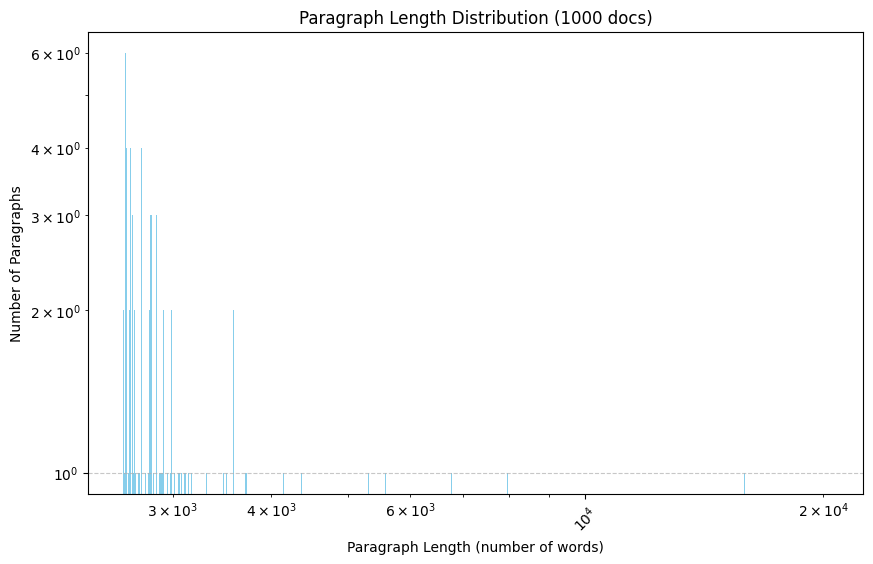

In [11]:
from collections import Counter
import matplotlib.pyplot as plt 

counters_para = Counter()

for doc in sample_langchain_docs:
    counters_para[len(doc.page_content.split())] +=1

lengths_sorted = sorted(counters_para.items())
lengths , counts = zip(*lengths_sorted)
# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(lengths, counts, color='skyblue')
plt.xlabel('Paragraph Length (number of words)')
plt.ylabel('Number of Paragraphs')
plt.title( f'Paragraph Length Distribution ({len(sample_langchain_docs)} docs)')
plt.xticks(rotation=45)
plt.xscale("log")
plt.yscale("log")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
from db_building import build_database_from_dataframe
from doc_building import compute_autokonenizer_chunk_size
from langchain.docstore.document import Document as LangchainDocument
from evaluation import RetrievalConfiguration
from config import MARKDOWN_SEPARATORS, DB_DIR_LOCAL, EMB_DEVICE
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter


def from_docs_to_vector_database(langchain_docs: List[LangchainDocument], mode: str = "random", top_n = 100, config: RetrievalConfiguration = None): 

    if mode=="random":
        top_documents = get_top_n_documents_with_largest_content(langchain_docs, n=100) 
        indices = np.random.randint(low=100, high=len(langchain_docs), size=top_n - 100, dtype=int)
        sample_langchain_docs = top_documents + [langchain_docs[i] for i in indices]
    elif mode=="top":
        sample_langchain_docs = get_top_n_documents_with_largest_content(langchain_docs, n=top_n) 

    autokenizer, chunk_size, chunk_overlap = compute_autokonenizer_chunk_size(config.get("embedding_model_name"))
    
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        autokenizer,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=MARKDOWN_SEPARATORS,
    )
    docs_processed = text_splitter.split_documents(sample_langchain_docs)

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    embedding_model = HuggingFaceEmbeddings(  # load from sentence transformers
        model_name=config.get("embedding_model_name"),
        model_kwargs={"device": EMB_DEVICE, "trust_remote_code": True},
        encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
        show_progress=False,
    )

    db = Chroma.from_documents(
        collection_name=config.get("collection"),
        documents=docs_processed_unique,
        persist_directory=DB_DIR_LOCAL,
        embedding=embedding_model,
    )
    

In [14]:
list_nb_docs = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

In [15]:
list_config = [ 
    RetrievalConfiguration(
        name=f'test_docs_{nb_docs}',
        database="chromadb",
        collection=f"Solon-embeddings-large-0.1_docs_{nb_docs}",
        database_path=None,
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type=None,
        reranker_name=None,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50]
        )
        for nb_docs in list_nb_docs
]

In [ ]:
for (config, nb_doc) in zip(list_config, list_nb_docs):
    from_docs_to_vector_database(langchain_docs=langchain_docs, mode="random", top_n=nb_doc, config=config)

In [ ]:
from evaluation import RetrievalEvaluator

results = RetrievalEvaluator.run(
    eval_configurations=list_config,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)

In [23]:
import matplotlib.pyplot as plt 
from typing import List, Dict 
import math

def hist_results(eval_configs: List[RetrievalConfiguration], results: Dict[str, Dict[str, Dict[int, float]]], 
                 ir_metrics: List[str] = ['recall', 'precision', 'mrr', 'ndcg'], focus: str = None, 
                 title: str = "", k: int = 15, cmap_name : str = 'tab20', x_min=0.6):
    """
    Plots histograms of IR metrics for different retrieval configurations at a given k.
    
    Parameters:
    - eval_configs: List of RetrievalConfiguration objects.
    - results: Dictionary of results where the keys are configuration names and values are dictionaries 
               of metrics.
    - ir_metrics: List of metrics to plot (default is ['recall', 'precision', 'mrr', 'ndcg']).
    - focus: The name of the config parameter to highlight in the legend.
    - title: The title of the plot.
    - k: The value of k to plot the histograms for.
    """
    num_metrics = len(ir_metrics)
    num_cols = math.ceil(math.sqrt(num_metrics))
    num_rows = math.ceil(num_metrics / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 10))
    axes = axes.flatten() if num_metrics > 1 else [axes]

    cmap = plt.get_cmap(cmap_name)
    colors = cmap(range(len(eval_configs)))

    for i, metric in enumerate(ir_metrics):
        ax = axes[i]
        values = []
        labels = []
        
        for j, config in enumerate(eval_configs):
            config_results = results.get(config.name, {})
            metric_values = config_results.get(metric, {})
            if isinstance(metric_values, dict):
                value = metric_values.get(k, None)
            else:
                value = metric_values
            
            if value is not None:
                values.append(value)
                label = config.get(focus) 
                if label is None:
                    label = config.name
                labels.append(label.split("/")[-1])
                ax.barh(labels[-1], values[-1], color=colors[j])
        
        ax.set_xlabel('Value')
        ax.set_ylabel('Configuration')
        ax.set_xlim(left=x_min)
        ax.set_title(f'{metric.upper()} at k={k}')
        ax.grid(True)
    
    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

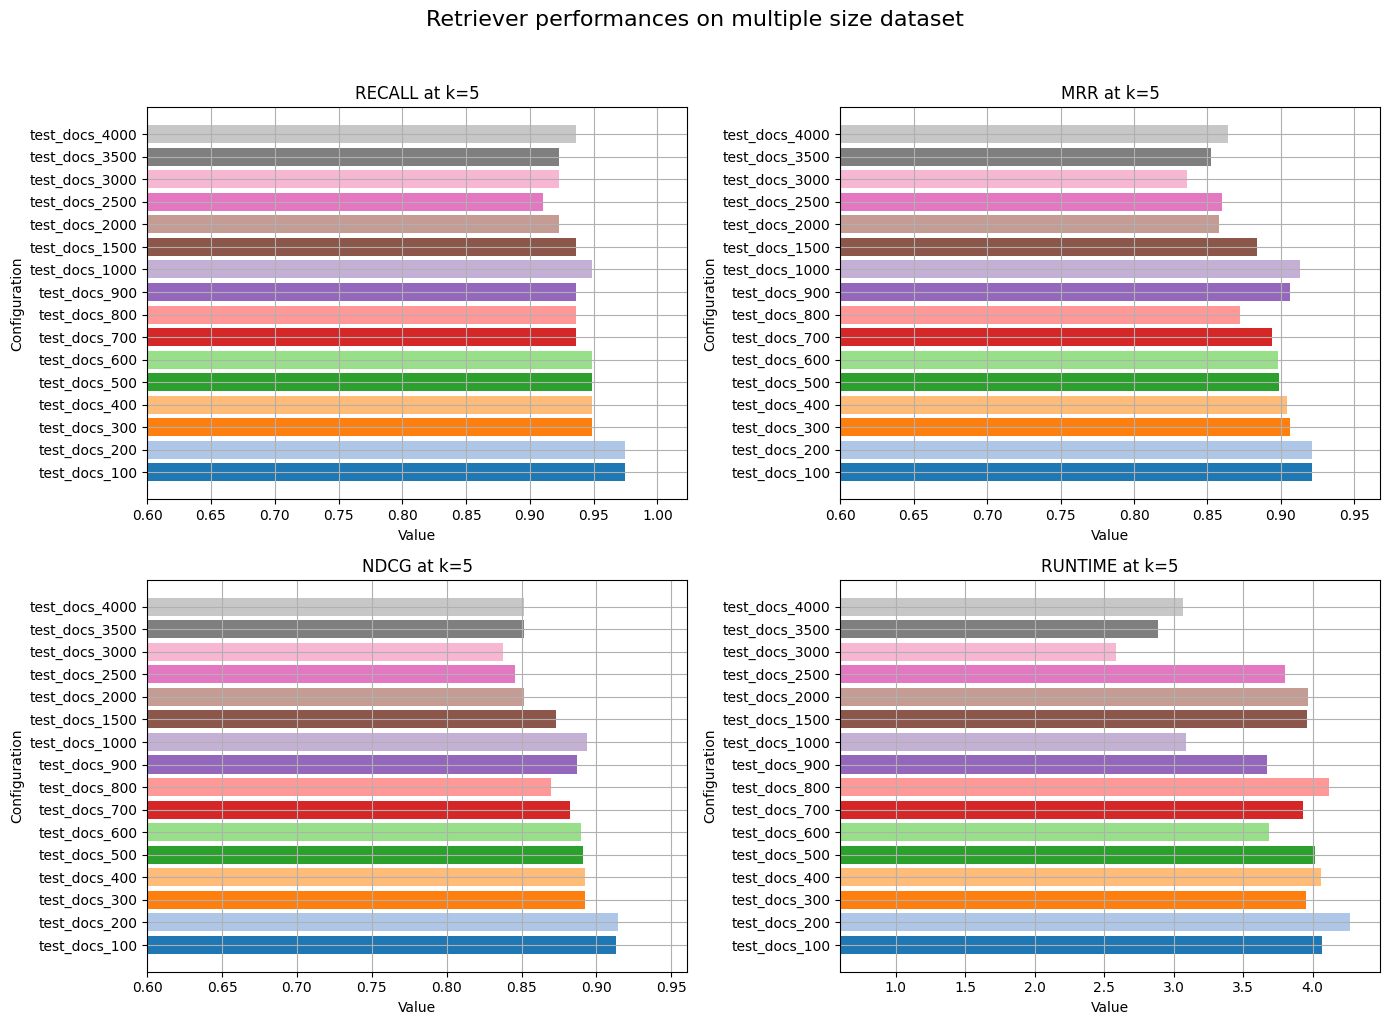

In [24]:
hist_results(
    list_config, 
    results["the_df_dataset"], 
    ir_metrics=['recall', 'mrr', 'ndcg','runtime'], 
    focus="name", 
    title = "Retriever performances on multiple size dataset",
    k = 5)

In [25]:

def plot_results(eval_configs: List[RetrievalConfiguration], results: Dict[str, Dict[str, Dict[int, float]]], 
                    ir_metrics: List[str] = ['recall', 'precision', 'mrr', 'ndcg'], focus: str = None, 
                    title: str = "", k: int = 15, cmap_name: str = "tab20"):
    """
    Plots IR metrics for different retrieval configurations.
    
    Parameters:
    - eval_configs: List of RetrievalConfiguration objects.
    - results: Dictionary of results where the keys are configuration names and values are dictionaries 
               of metrics.
    - ir_metrics: List of metrics to plot (default is ['recall', 'precision', 'mrr', 'ndcg']).
    - focus: The name of the config parameter to highlight in the legend.
    - title: The title of the plot.
    - k: The maximum value of k to plot.
    """

    # dynamic plotting  
    num_metrics = len(ir_metrics)
    num_cols = math.ceil(math.sqrt(num_metrics))
    num_rows = math.ceil(num_metrics / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 10))
    axes = axes.flatten() if num_metrics > 1 else [axes]

    cmap = plt.get_cmap(cmap_name)
    colors = cmap(range(len(eval_configs)))
    
    for i, metric in enumerate(ir_metrics):
        ax = axes[i]

        for j, config in enumerate(eval_configs):
            config_results = results.get(config.name, {})
            metric_values = config_results.get(metric, {})
            
            k_values = [key for key in config.k_values if key <= k]
            values = [metric_values.get(ki, None) for ki in k_values]

            label = config.get(focus) 

            if label is None:
                label = config.name
            ax.plot(k_values, values, marker='o', label=label.split("/")[-1], color=colors[j])
        
        ax.set_xlabel('k')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.upper()} vs k')
        ax.set_xticks(k_values)
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

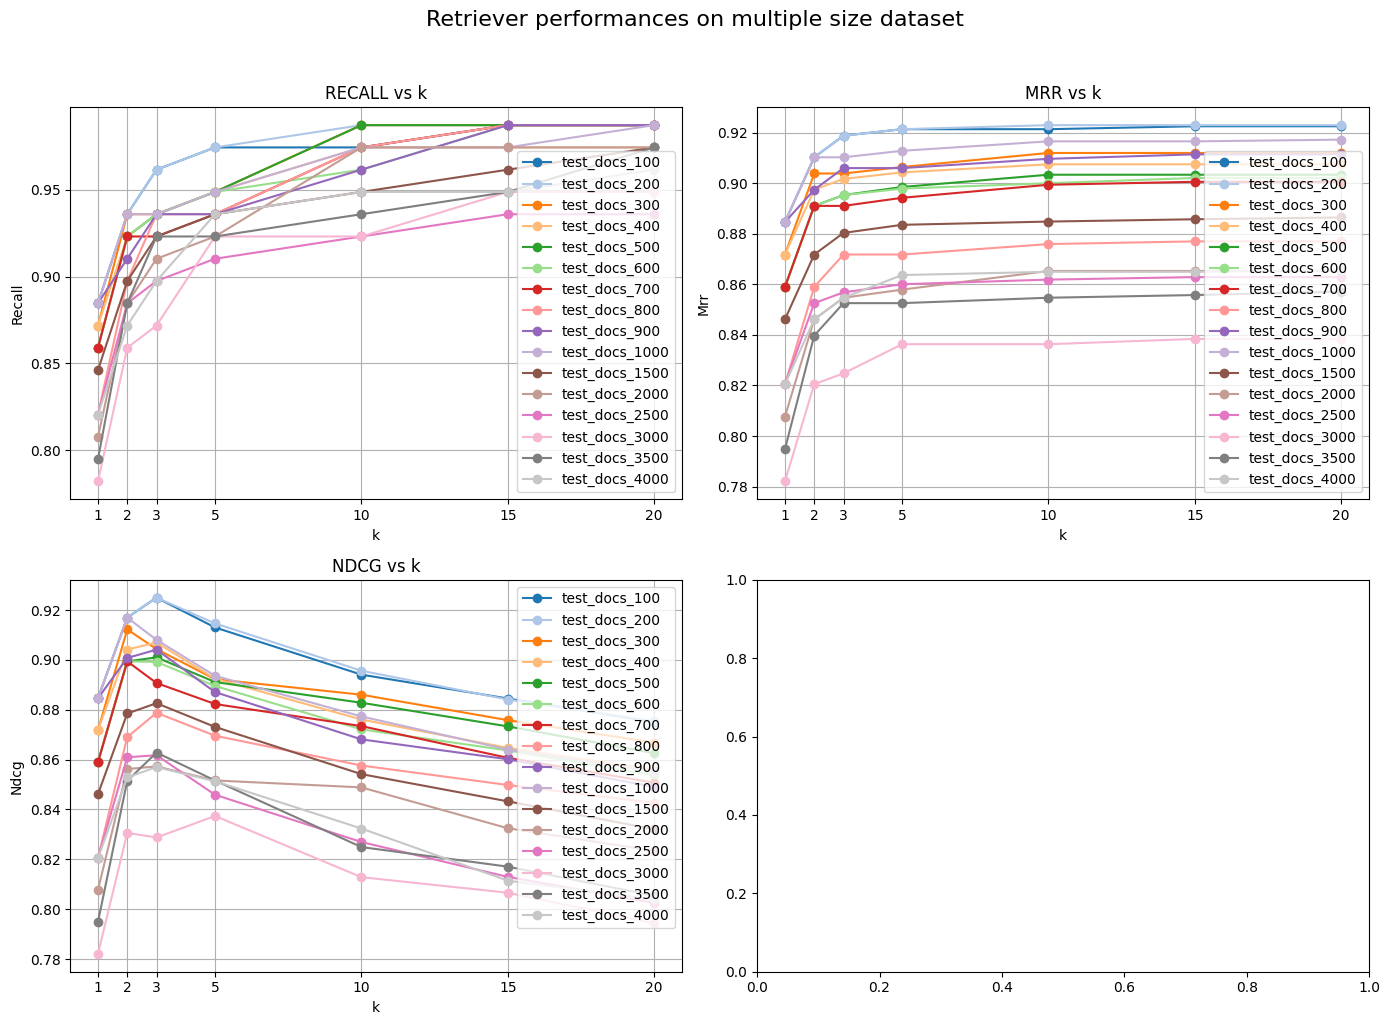

In [26]:
plot_results(
    list_config, 
    results["the_df_dataset"], 
    ir_metrics=['recall', 'mrr', 'ndcg'], 
    focus="name", 
    title = "Retriever performances on multiple size dataset",
    k = 20)